In [2]:
!pip install hdbscan
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 53.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp39-cp39-linux_x86_64.whl size=3584987 sha256=7c9eb05fa188f34ca8f3a11d2d996ed27d1de139a444485cdc0bdd2cda962fa8
  Stored in directory: /root/.cache/pip/wheels/28/5e/ed/5989da4cc423a222a47cbb4fde5d6c0eff4590d922e45f233c
Successfully built hdbscan


In [3]:
import hdbscan
import pandas as pd
import numpy as np
#%matplotlib ipympl
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
from ipywidgets import interact, Output
from IPython.display import clear_output

import sys
sys.path.append('..')
sys.path.append('../autoencoder')

from src.band_plotters import*
from src.Tiff32Image import*
from models import*

In [4]:
FINGERPRINT_LENGTH = 4
FINGERPRINT_NAME = "12_bands_encoder_L={0}".format(FINGERPRINT_LENGTH)
PERPLEXITY = 30
FLAT_ONLY = True
BORING_COLUMNS = ["flat_segments", "flatness_score", "binary_flatness", "horz_flat_seg", "exfoliation_eg", "A", "B", "C", "D", "E", "F"]
INPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"

## Load Data

In [5]:
df = pd.read_csv(f"../fingerprints/{INPUT_NAME}", index_col="ID")
if FLAT_ONLY:
    df = df[df.horz_flat_seg>0]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,sg_sto_group,percentage_flat,relative_id,crystal_system,0,1,2,3,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,1,3,0.095794,...,276.0,24.2,2dm-5155,triclinic,-0.121399,0.068466,0.028213,0.075176,-15.556751,11.918595
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,1,1,0.097255,...,652.0,85.2,2dm-3549,trigonal,-0.122216,0.068695,0.028170,0.075225,12.417899,9.612834
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,1,4,0.037593,...,377.0,5.8,2dm-3869,trigonal,-0.122388,0.069232,0.028047,0.075471,38.951950,-12.535301
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,1,2,0.140290,...,726.0,23.9,2dm-3290,tetragonal,-0.121349,0.068556,0.027937,0.074796,-28.288467,6.352117
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,1,3,0.067035,...,276.0,24.2,2dm-4682,triclinic,-0.121570,0.068578,0.027572,0.075048,-26.508755,-7.839354


## Cluster

In [6]:
fingerprint_cols = [str(i) for i in range(FINGERPRINT_LENGTH)]
BORING_COLUMNS += fingerprint_cols

In [10]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='manhattan', cluster_selection_method='eom', min_cluster_size=4, min_samples=3, p=0.2)
clusterer.fit(df[fingerprint_cols])

df["labels"] = clusterer.labels_


# View cluster for auto-encoded fingerprint


In [25]:
# change path to the location of the desired trained model
model_path = "../autoencoder/trained_models/nearest_12_v1_length_{0}.pkl".format(FINGERPRINT_LENGTH)
# name of the energy{name} folder which holds the input band tensors
CNN_input_file_index = "_12_nearest_bands"
# load the model that we have already trained on the data
trained_model = load_learner(model_path)

def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        #ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
        ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
        
        ax[i].set_xlabel(index)
        
    for i, index in enumerate(df[df.labels==label].index):
        plot(index)
        view_prediction(index, trained_model.model, -17, 20, width=128)

#interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))
interact(view_cluster, label=(43))

interactive(children=(IntSlider(value=43, description='label', max=129, min=-43), Output()), _dom_classes=('wi…

<function __main__.view_cluster(label)>

# View cluster for any fingerprint

In [18]:
def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    #fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        plt.plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        # # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
        # ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
        plt.xlabel(index)
        plt.title("fingerprint")
        plt.show()
        plot(index)
    

interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

interactive(children=(IntSlider(value=25, description='label', max=52, min=-1), Output()), _dom_classes=('widg…

<function __main__.view_cluster(label)>

## Rerun TSNE (ONLY IF ON FLAT SUBSET)

In [8]:
if FLAT_ONLY:
    tsne = manifold.TSNE(n_components=2, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=30 ,n_iter=10000, verbose=2)
    fingerprint_2d = tsne.fit_transform(df[fingerprint_cols])
    df.fx, df.fy = fingerprint_2d[:, 0], fingerprint_2d[:, 1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.002s...
[t-SNE] Computed neighbors for 2005 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 0.000096
[t-SNE] Computed conditional probabilities in 0.194s


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 64.7775269, gradient norm = 0.0163006 (50 iterations in 2.309s)
[t-SNE] Iteration 100: error = 63.4040108, gradient norm = 0.0011015 (50 iterations in 1.870s)
[t-SNE] Iteration 150: error = 63.2923851, gradient norm = 0.0003234 (50 iterations in 1.436s)
[t-SNE] Iteration 200: error = 63.2761803, gradient norm = 0.0000727 (50 iterations in 1.732s)
[t-SNE] Iteration 250: error = 63.2732773, gradient norm = 0.0000469 (50 iterations in 1.796s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.273277
[t-SNE] Iteration 300: error = 1.1157304, gradient norm = 0.0012509 (50 iterations in 1.724s)
[t-SNE] Iteration 350: error = 0.8845183, gradient norm = 0.0004678 (50 iterations in 1.900s)
[t-SNE] Iteration 400: error = 0.8068614, gradient norm = 0.0002536 (50 iterations in 1.939s)
[t-SNE] Iteration 450: error = 0.7717554, gradient norm = 0.0001697 (50 iterations in 1.875s)
[t-SNE] Iteration 500: error = 0.7544154, gradient norm = 0.0001377 (50 

## Plots

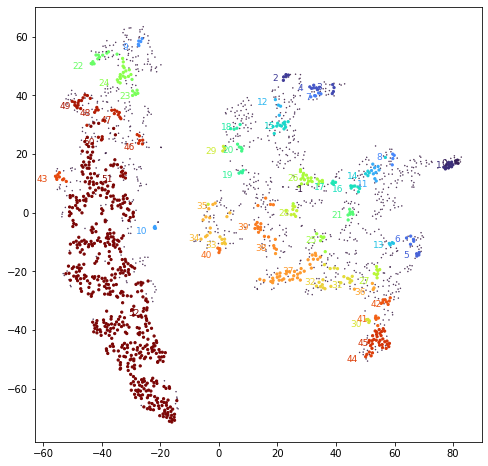

In [11]:
labels = clusterer.labels_

fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2
 
unique_label,cluster_rep_index, counts = np.unique(labels, return_index=True, return_counts=True)
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
    
for rep_id in cluster_rep_index:
        col=cmap(norm(labels[rep_id]))
        plt.annotate(labels[rep_id],fingerprint_2d[rep_id,:]+[-4.5,-1],color=col,alpha=1, weight='normal', ha='center', va='center', size=9).draggable()

plt.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")
plt.show()

Output()

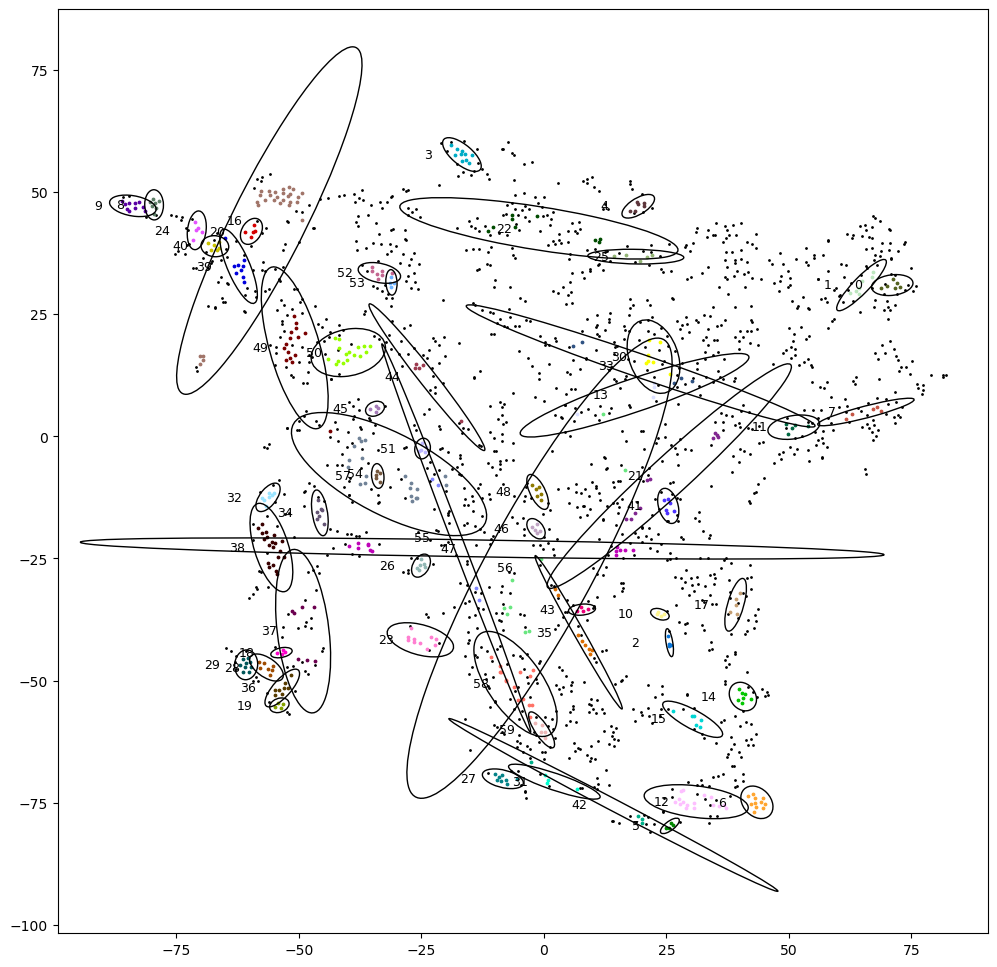

In [17]:
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
display(out)

fig, ax = plt.subplots(figsize=(12, 12))
ax = plot_groups(df,"labels", ax=ax)
ax = plot_cluster_ellipses(df, ax=ax, color="black")
# ax.legend()

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

Output()

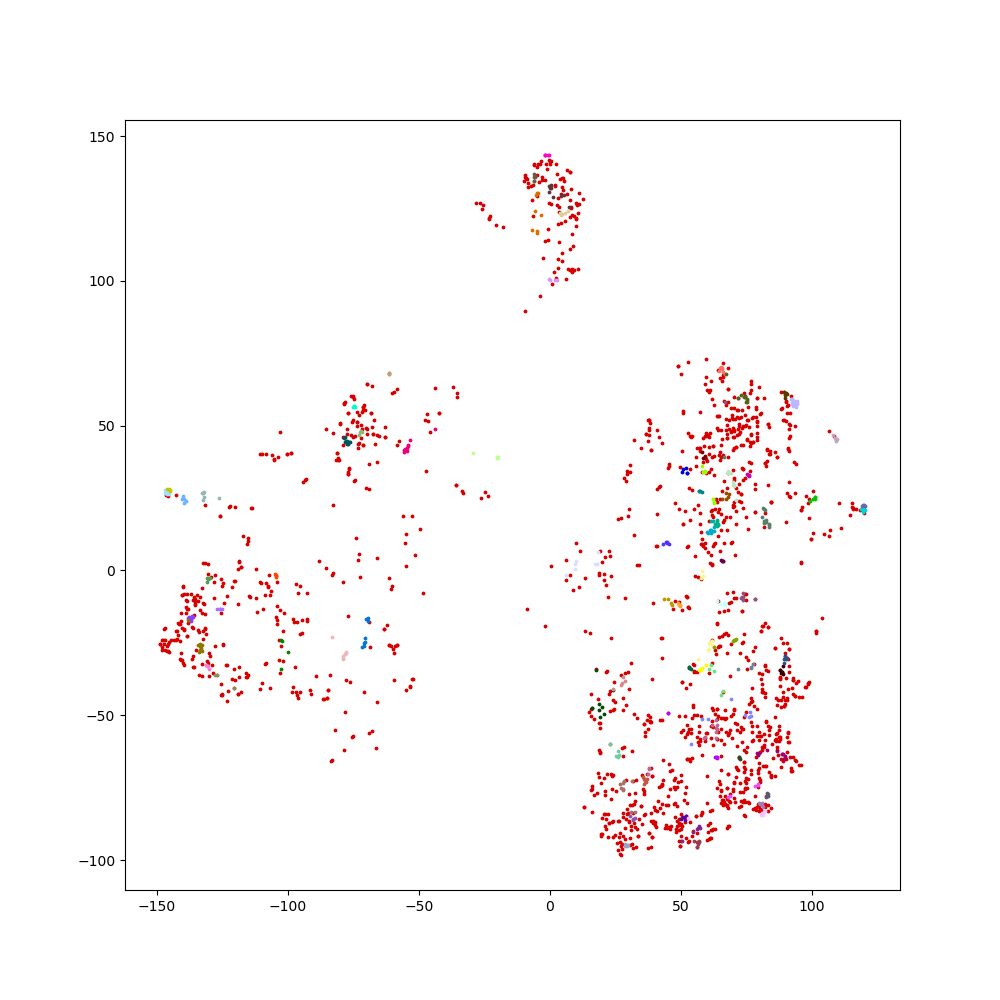

In [12]:
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
display(out)

fig, ax = plt.subplots(figsize=(10, 10))
ax = plot_groups(df,"labels", ax=ax)
#ax = plot_cluster_ellipses(df, ax=ax, color="black")
# ax.legend()

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()